# Image Classification

- Tuning VGG16

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load Dataset & Preprocess

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')


In [5]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


In [6]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 
print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [8]:
# param initialization

batch_size = 16
epochs = 10
IMG_SIZE = 128

In [9]:
# imshow data

def plot_images(img_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(img_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()

In [10]:
# data aug

image_gen_train = ImageDataGenerator(rescale = 1./255,
                                    rotation_range=0.3,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=False)

In [11]:
# create pipeline to connect dir <> workspace

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                    directory=train_dir,
                                                    shuffle=True,
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    class_mode='binary')


Found 2000 images belonging to 2 classes.


In [12]:
train_data_gen[0][0].shape

(16, 128, 128, 3)

In [13]:
# val data only needs scaling

image_gen_val = ImageDataGenerator(rescale = 1./255)

In [14]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SIZE, IMG_SIZE),
                                                 class_mode='binary')


Found 1000 images belonging to 2 classes.


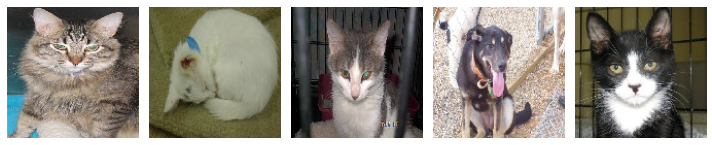

In [21]:
sample_train_img, _ = next(val_data_gen)
plot_images(sample_train_img[:5])

## Build VGG16 Model

In [15]:
# 문제1-1. 이미지에 나온 VGG16 모델을 구현하세요.  

input_layer=tf.keras.layers.Input(shape=(128, 128, 3))
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(512, activation='relu')(x)
x=tf.keras.layers.Dense(128, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928 

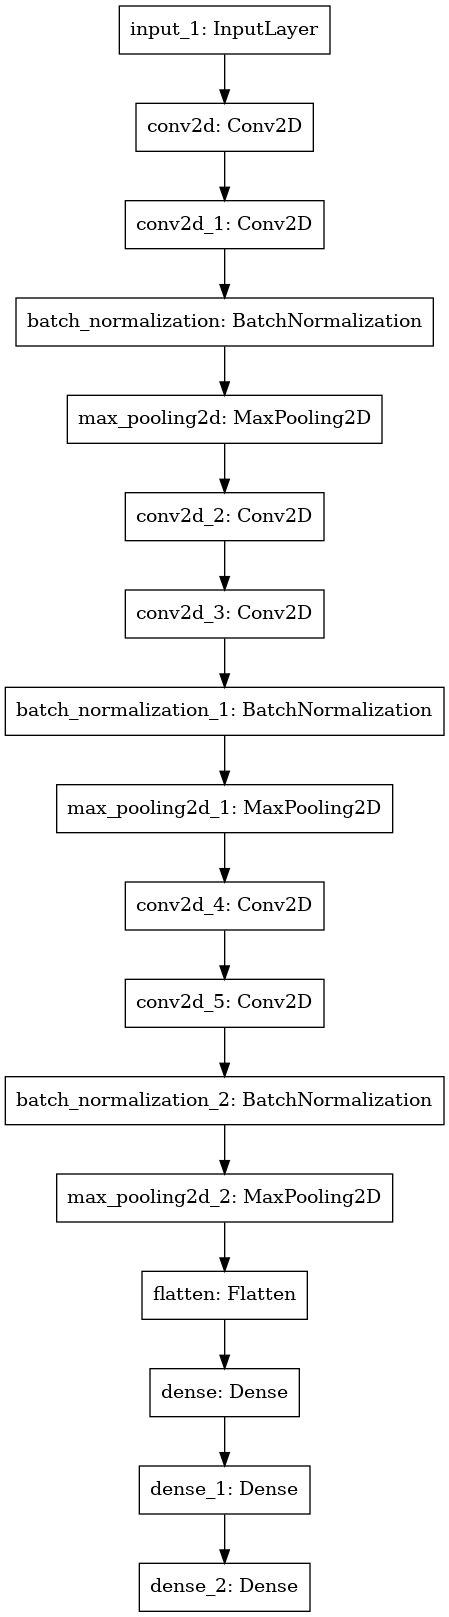

In [16]:
from tensorflow.keras import utils

utils.plot_model(model)

In [17]:
# compile model

loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy

model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]




In [18]:
history = model.fit(train_data_gen,
                    steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen,
#                     callbacks=callbacks_list,
                    validation_freq=1
)


Epoch 1/10
125/125 [==============================] - 55s 119ms/step - loss: 4.3357 - binary_accuracy: 0.5100 - val_loss: 1.8533 - val_binary_accuracy: 0.5760
Epoch 2/10
125/125 [==============================] - 14s 113ms/step - loss: 0.6951 - binary_accuracy: 0.4935 - val_loss: 0.7089 - val_binary_accuracy: 0.4920
Epoch 3/10
125/125 [==============================] - 14s 113ms/step - loss: 0.6933 - binary_accuracy: 0.5000 - val_loss: 0.6934 - val_binary_accuracy: 0.5000
Epoch 4/10
125/125 [==============================] - 14s 111ms/step - loss: 0.6933 - binary_accuracy: 0.5070 - val_loss: 0.6933 - val_binary_accuracy: 0.5000
Epoch 5/10
125/125 [==============================] - 14s 112ms/step - loss: 0.6937 - binary_accuracy: 0.4950 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 6/10
125/125 [==============================] - 14s 111ms/step - loss: 0.6938 - binary_accuracy: 0.4900 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 7/10
125/125 [==========================

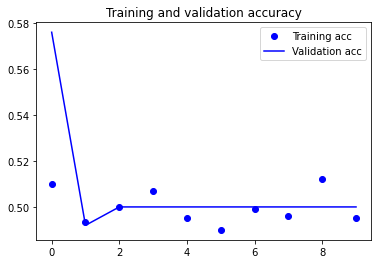

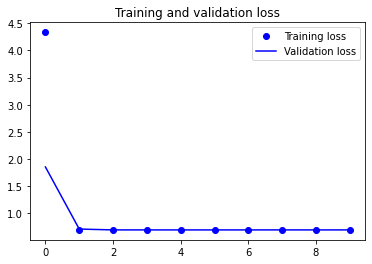

In [19]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Object Detection

In [24]:
!pip3 install tensorflow-estimator==2.6.0

In [25]:
# use pre-trained model

import tensorflow as tf
import tensorflow_hub as hub


# for img download
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# line, font for img
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import time


In [26]:
# img viz func

def display_img(img):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(img)

In [36]:
# img download and resizing func

def download_resize_img(url, new_width=128, new_height=128, display=False):
    
    _, filename = tempfile.mkstemp(suffix='.jpg')
    response = urlopen(url)
    img_data = response.read()
    img_data = BytesIO(img_data) # read img
    pil_img = Image.open(img_data)
    pil_img = ImageOps.fit(pil_img, (new_height, new_width), Image.ANTIALIAS) # resize
    pil_img_rgb = pil_img.convert('RGB')
    pil_img_rgb.save(filename, format='JPEG', quality=90) #save img
    print('img downloaded to %s.' % filename)
    
    if display:
        display_img(pil_img)
    return filename


In [33]:
# func for Bbox

def draw_bbox(img,
             ymin, xmin, ymax, xmax,
             color,
             font,
             thickness=4,
             display_str_list=()):
    
    draw = ImageDraw.Draw(img)
    im_width, im_height = img.size
    
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                 ymin * im_height, ymax * im_height)
    
    # draw bbox lines
    
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
             width=thickness,
             fill=color)
    
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height -2 * margin),
                       (left + text_width, text_bottom)],
                      fill=color)
        
        draw.text((left + margin, text_bottom - text_height - margin),
                 display_str,
                 fill='black',
                 font=font)
        
        text_bottom -= text_height -2 * margin
    
    

In [34]:
# get class and score

def draw_boxes(img, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    colors = list(ImageColor.colormap.values())
    
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)

    except IOError:
        print('font not found. using default font')
        font = ImageFont.load_default()
        
# now draw bbox

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i]) # box coordinate
            display_str = '{}: {}%'.format(class_names[i].decode('ascii'),
                                          int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            img_pil = Image.fromarray(np.uint9(img)).convert('RGB')
            draw_bbox(image_pil,
                     ymin,
                     xmin,
                     ymax,
                     xmax,
                     color,
                     font,
                     display_str_list=[display_str])
            np.copyto(img, np.array(img_pil))
        return img
    

img downloaded to /tmp/tmp3920_1ht.jpg.


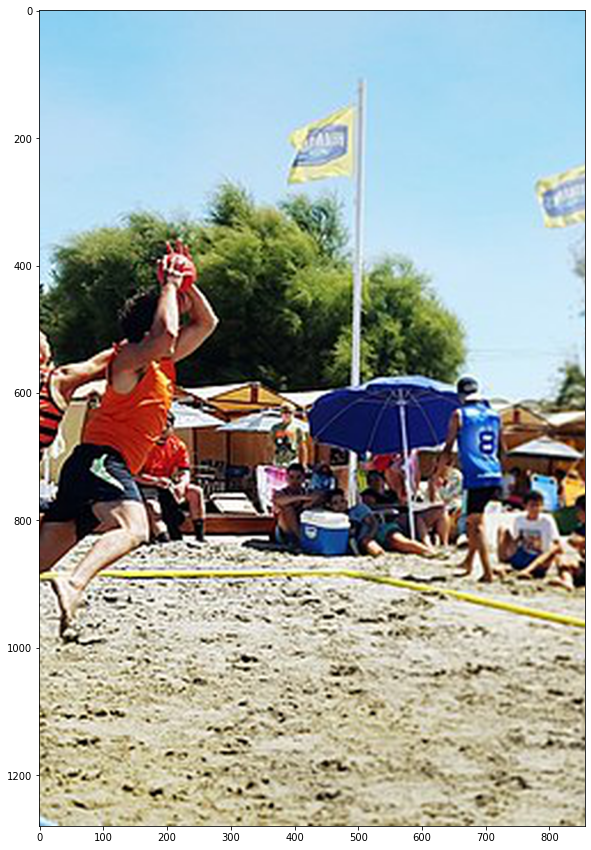

In [37]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Torneo_beach_handball.jpg/640px-Torneo_beach_handball.jpg"
downloaded_image_path = download_resize_img(image_url, 1280, 856, True)  # new_width와 new_height를 변경해 보세요.


In [38]:
# bring pre-trained model - Faster RCNN

module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"  

detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    
    return img


# 회고
1. Classification
    - 0.5 밖에 안나온다. 커널이 계속 죽여서 이미지 사이즈도 레이어 개수도 피처 수도 계속 줄인건데... 더 키워봤자 학습이 진행이 안 될 것 같다
    - 모델 트레이닝은 정말 거대자본만 할 수 있는건가! transfer learning 이 시급하다